<a href="https://colab.research.google.com/github/khslahoriya/cap-comp215/blob/main/lab06_GoL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

COMP 215 - LAB 6 (Game of Life)
-----------------------------------------------
#### Name: Kunwar
#### Date:

This lab exercise is an introduction to [Conway's Game of Life](https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life) discovered and studied by [John Conway](https://en.wikipedia.org/wiki/John_Horton_Conway).

**New Python concepts**:
   * 2D numpy [array](https://numpy.org/doc/stable/reference/generated/numpy.array.html)
   * basic [array operations](https://www.pluralsight.com/guides/overview-basic-numpy-operations)

**New Computation concepts**:
   * [2D sliding dot product](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate2d.html)
   * [Animation](https://matplotlib.org/stable/api/animation_api.html)

**Credits**:
    Code examples based on [Think Complexity, 2nd edition](https://thinkcomplex.com).
    Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

As usual, the first code cell simply imports all the modules we'll be using...

In [122]:
import time
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
from scipy.signal import correlate2d

%matplotlib inline
# Configure matplotlib's animation library to work in the browser.
matplotlib.rc('animation', html='jshtml')

A reusable function for plotting 2D numpy.array as an image...

In [123]:
def plot_2d_array(array, axes=None, title='', cmap='Blues', **options):
    """
    Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue.

    :param axes: the axes to plot on, or None to use the `plt.gca()` (current axes)
    :param options: keyword arguments passed directly to `plt.imshow()`
           see https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html
    """
    axes = axes or plt.gca()  # If not axes are provided, draw on current axes
    axes.set_title(title)
    # Turn off axes labels and tick marks
    axes.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False ,
                     labelbottom=False, labeltop=False, labelleft=False, labelright=False,)
    # Defaults for displaying a "matrix" with hard-pixel boundaries and (0,0) at top-left
    options = {**dict(interpolation='nearest', origin='upper'), **options}
    axes.imshow(array, cmap=cmap, **options)

## Life Fundamentals
Both the textbook and our week6 notebooks develop some fundamental operations for simulating the Game of Life.
Some of the code from `week6.ipynb` is reproduced here without deriving all the ideas - review `week6.ipynb` notebook for the full story.
The sliding dot product algorithm in `step` is implemented with [scipy.signal.correlate2d](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate2d.html).  It's behaviour is identical to the derivation in `week6.ipynb`.

#### Notes
* we use `correlate2d(state, kernel, mode='same', boundary='wrap')` to pad state matrix with 1 value around perimeter from the opposite side of the matrix.
* since the rule is a 1D `np.array`, we use "vector indexing" here to set the 'live' state transitions:  `next_state[[3, 12, 13]] = 1`

In [124]:
class Life2D:
    """ An basic 2D Cellular Automata that implementes Conway's Game of Life """
    kernel = np.array([[1, 1, 1],
                       [1, 10, 1],
                       [1, 1, 1]])

    next_state = np.zeros(19, dtype=np.uint8)
    next_state[[3, 12, 13]] = 1

    def __init__(self, n_rows, n_cols=None):
        """ Construct a n_rows x n_cols 2D CA """
        n_cols = n_cols or n_rows  # i.e., n_cols if n_cols is not None and n_cols != 0 else n_rows
        self.state = np.zeros(shape=(n_rows, n_cols), dtype=np.uint8)

    def step(self):
        """Executes one time step. """
        transitions = correlate2d(self.state, self.kernel, mode='same', boundary='wrap')
        self.state = self.next_state[transitions]

    def draw(self, axes=None, step=''):
        axes = axes or plt.gca()   # use pyplot's current axes if none are provided.
        plot_2d_array(self.state, axes, title=f"Conway's Game of Life {step}")

### Visualizing a 2D simulation model
For 1D CAs, we could use a 2D image to visualize the CA progression over time.
For 2D CAs, we could try using time as a 3rd axis to generate a 3D visualziation, but without VR, its hard to explore a 3D visualization.
Instead, we'll use a simple 2D ["stop motion" animation](https://en.wikipedia.org/wiki/Animation).
Here is a generic class that animates any 2D model that provides step() and draw() methods, and uses matplotlib to render its state.

See [Matplotlib animation in Jupyter](https://www.allendowney.com/blog/2019/07/25/matplotlib-animation-in-jupyter/) by our textbook author for a discussion of the pros and cons of various animation techniques in jupyter notebooks.

In [125]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number
    """

    def __init__(self, model, frames=50, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            self.model.step()
        self.model.draw(self.ax, step=step)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()          # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)     # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()               # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

### Sample usage
Animate a single glider...

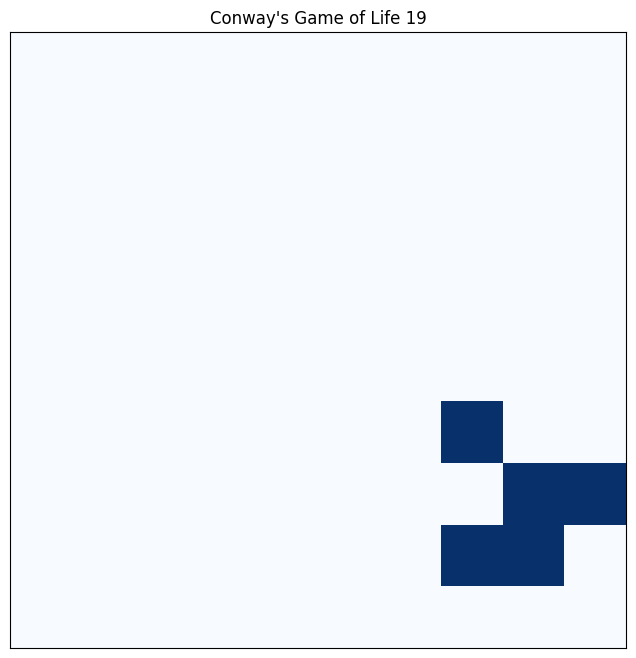

In [115]:
size = 10
life = Life2D(size)
glider = np.array([[0, 1, 0], [0, 0, 1], [1, 1, 1]], dtype=np.uint8)
life.state[1:4, 2:5] = glider             # bad idea to alter an objects state directly!  We'll improve it in Ex. 3
gol = Animation2D(life, frames=20)
gol.animate()

## Exercise 1:  Enumerate all Elementary 2D CA's
Write a line or 2 of code to compute and print the answer for each question:
* how many unique states are there for a 3x3 (9 cell) neighbourhood?

There are 2^(3*3)= 2^9 =512 unique states for a 3x3 (9 cell) neighborhood, as each cell can be in one of two states (alive or dead), and there are 9 cells in the neighborhood.
* how many unique “rules” are there? (where a rule provides a mapping for each possible neighbourhood state to the output for the centre cell)

For each neighborhood state (512 possible states), there are 2 possible outcomes (the center cell can be alive or dead). Therefore, there are 2^512 unique rules for a 3x3 neighborhood.
* how does this number compare, for example, to the [number of atoms in the observable universe?](https://en.wikipedia.org/wiki/Observable_universe#Matter_content%E2%80%94number_of_atoms)

The estimated number of atoms in the observable universe is about 10^80 . The number of unique rules for a 3x3 neighborhood ( 2^512 ) is astronomically larger than the number of atoms in the observable universe.

In [116]:
# Ex. 1 your code here...
unique_states = 2**(3*3)
unique_states

unique_rules = 2**unique_states
unique_rules

atoms_in_universe = 10**80
atoms_in_universe


100000000000000000000000000000000000000000000000000000000000000000000000000000000

Using what you learned above, concisely answer each question below (point form)1
1. would it be a reasonable goal to conduct an experiment like Wolfram’s for 2D CA’s?
2. propose a numbering scheme for these rules, analogous to Wolfram’s rule numbers
3. how might we go about determining which rule number corresponds to Conway’s GoL?
   (I’m not asking for the number, but rather for a method you could use to find it.)

#### Ex 1. Your Answers

1. I think conducting an experiment like Wolfram’s for 2D CA’s would be highly impractical due to a huge number of unique rules, which makes it difficult to explore and categorize them all.
2. . A numbering scheme for these rules could involve assigning each rule a unique identifier based on the binary representation of its outcomes for all possible neighborhood states, similar to Wolfram’s rule numbers.
3. . To find the rule number that makes a pattern like Conway's Game of Life, we try lots of rules on a starting pattern that looks like a glider in GoL. We then see which rule makes patterns that look most like GoL's patterns. That rule is probably the one for Conway's GoL.

## Exercise 2: random_life
Extend the Life2D class defined above to allow the game to be initialized with a random start state.
The liklihood of any given cell being initialized to "alive" is given by $p$.
*Hint*: we did this exact exercise for a 1D array in previous lab

In [117]:
# Ex. 2 experimental setup

class BetterLife2D(Life2D):
    """ Improvements on the basic Life2D model """

    def randomize_state(self, p):
        """ Randomize the state of this GoL, where probability of a "live" cell is p """
        # Ex. 2 your code here...
        self.state = np.random.choice([0, 1], size=self.state.shape, p=[1-p, p]) #alike to lab5


def random_life(n_rows, n_cols=None, p=0.5):
    """ Return a Life2D object of given dimensions with initial randomized state where "live" cells have probability p """
    # Ex. 2 your code here...
    n_cols = n_cols or n_rows
    life = BetterLife2D(n_rows, n_cols)
    life.randomize_state(p)
    return life


### Experiment
Run a small experiment to see if you can identify any relationship between $p$, the probability of a live cell in the initial grid, and the time it takes for the GoL pattern to stabilize.

In [118]:
# Ex. 2 write code for your experiment here...
#Range of probabilities to test
probabilities = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

stabilization_times = {}

stabilization_steps = 10

def run_experiment():
    for p in probabilities:
        # Initialize a random Life2D object with given probability
        life = random_life(n_rows=50, n_cols=50, p=p)

        # Perform steps until stabilization
        for step in range(stabilization_steps):
            life.step()
            current_state = life.state

            # Check if the state has stabilized
            if step > 0 and np.array_equal(current_state, previous_state):
                stabilization_times[p] = step
                print(f"Probability p={p}: Stabilization time = {step} steps")
                break

            previous_state = current_state.copy()

run_experiment()

Probability p=0.8: Stabilization time = 2 steps
Probability p=0.9: Stabilization time = 2 steps


## Exercise 3: Load Patterns
People have discovered many interesting ["patterns"](https://conwaylife.com/wiki/Category:Patterns) that exhibit various types of behaviours.
A "pattern" is just a small 2D array.
 1. Develop a function that returns a 2D array containing the patterns defined by a single string; and
 2. Add a `load_pattern(x, y, pattern)` method to your `BetterLife2D` class above to insert patterns into the Life state array
    *Tip*: you can [assign an entire 2D slice of a numpy array](https://www.nickmccullum.com/advanced-python/numpy-indexing-assignment/) in a single assignment statement!   See example in the Sample Usage block above. Try it!

In [119]:
def pattern_from_string(pattern_string):
    return np.array([[int(char) for char in line.strip()] for line in pattern_string.strip().split('\n')])

class BetterLife2D(Life2D):
    def load_pattern(self, x, y, pattern):
        height, width = pattern.shape
        self.state[x:x+height, y:y+width] = pattern

# Example usage
my_pattern = \
    """
    000
    010
    101
    """

glider_array = pattern_from_string(my_pattern)
life = BetterLife2D(n_rows=10, n_cols=10)
life.load_pattern(1, 1, glider_array)
life.state

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

### Define some patterns
User your nifty new function to define a few common, interesting patterns (e.g., from the book or other sources)

In [120]:
# Ex. 3 define your patterns here...
blinker_pattern = \
    """
    010
    010
    010
    """
blinker_array = pattern_from_string(blinker_pattern)

beacon_pattern = \
    """
    1100
    1100
    0011
    0011
    """
beacon_array = pattern_from_string(beacon_pattern)

lwss_pattern = \
    """
    01001
    10000
    10001
    11110
    """
lwss_array = pattern_from_string(lwss_pattern)

print(blinker_array)
print(beacon_array)
print(lwss_array)

[[0 1 0]
 [0 1 0]
 [0 1 0]]
[[1 1 0 0]
 [1 1 0 0]
 [0 0 1 1]
 [0 0 1 1]]
[[0 1 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 1]
 [1 1 1 1 0]]


### Experiment
Load up a BetterLife2D object with some patterns that interact in some interesting way.
What can we learn from studying interactions like this?   Is anything here applicable to the real world?

ANS - Well I believe studying interactions like this can treach us many things such as the effect of one pattern on the other and also it can explain about the behaviours of various patterns which can further teach us about the oscillations or stabalization in the patterns.

This is applicable in real world also as this can tecah us about the various patterns in almost all scientific fields like it can tell about crystal patterns for physics, bacteria colony patterns for biology, image processing in computer science and urban planning patterns in sociology.

In [121]:
# Ex. 3 code for your experiment here
# Initialize BetterLife2D object
life = BetterLife2D(n_rows=10, n_cols=10)

# Load patterns into the BetterLife2D object
life.load_pattern(1, 1, blinker_array)
life.load_pattern(5, 5, beacon_array)

# Perform multiple steps to observe pattern interactions
num_steps = 10
for step in range(num_steps):
    life.step()
    print(f"Step {step + 1}:")
    print(life.state)
    print()

Step 1:
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 1 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 1 1 0]
 [0 0 0 0 0 0 0 0 0 0]]

Step 2:
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 0 0 0]
 [0 0 0 0 0 1 1 0 0 0]
 [0 0 0 0 0 0 0 1 1 0]
 [0 0 0 0 0 0 0 1 1 0]
 [0 0 0 0 0 0 0 0 0 0]]

Step 3:
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 1 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 1 1 0]
 [0 0 0 0 0 0 0 0 0 0]]

Step 4:
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 0 0 0]
 [0 0 0 0 0 1 1 0 0 0]
 [0 0 0 0 0 0 0 1 1 0]
 [0 0 0 0 0 0 0 1 1 0]
 [0 0 0 0 0 0 0 0 0 0]]

Step 5:
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0